图像预处理部分
利用os和opencv导入图片库，并对其进行resize，使符合网络需求。
1.导入imgs.zip中的图片以及driver_imgs_list.csv
#listdir的参数是文件夹的路径
#resize可以缩放图片可参考如下
http://www.xuebuyuan.com/1971769.html

In [29]:
import os
import shutil
import numpy as np
import pandas as pd

def rmrf_mkdir(dirname):
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)

def transfer_image(driver,targetpath):
    np.random.seed(2016)
    path = ".\\imgs\\train\\"
    images = datacsv.loc[(datacsv['subject']==driver),['img']]
    classnames = datacsv.loc[(datacsv['subject']==driver),['classname']] 

    for i in range(len(images)):
        resource = "".join(os.path.join(path,classnames.values[i],images.values[i]))
        target = "".join(os.path.join(targetpath,classnames.values[i],images.values[i]))
        shutil.copy(resource,target)
    pass

# 根据驾驶员分割训练集和验证集
x_drivers = []
y_drivers = []
datacsv = pd.DataFrame(pd.read_csv('driver_imgs_list.csv'))
x_drivers = datacsv['subject'].unique()[:24]
y_drivers = datacsv['subject'].unique()[24:]

# 重新建立目标文件树
rmrf_mkdir(".\\data\\")
print('\\data\\ recreate') 
os.makedirs(".\\data\\test\\")
for c in ["c0","c1","c2","c3","c4","c5","c6","c7","c8","c9"]: 
    os.makedirs(".\\data\\train\\{0}\\".format(c))
    os.makedirs(".\\data\\validation\\{0}\\".format(c))
print('folders created !') 

# 复制文件到目标文件夹下
for driver in x_drivers:
    transfer_image(driver, targetpath=".\\data\\train\\")
    print (driver)
for driver in y_drivers:
    transfer_image(driver,targetpath=".\\data\\validation\\")
    print (driver)
for file in os.listdir(".\\imgs\\test\\val\\"):
    resource = "".join(os.path.join(".\\imgs\\test\\val\\",file))
    target = "".join(os.path.join(".\\data\\test\\",file))
    shutil.copy(resource,target)

\data\ recreate
folders created !
p002
p012
p014
p015
p016
p021
p022
p024
p026
p035
p039
p041
p042
p045
p047
p049
p050
p051
p052
p056
p061
p064
p066
p072
p075
p081


In [3]:
# from keras.models import Model
# from keras.layers import Input, Lambda, Dense, Dropout
# from keras.preprocessing.image import ImageDataGenerator
# from keras.layers.pooling import GlobalAveragePooling2D
# from keras.applications import ResNet50,InceptionV3,Xception
# import h5py

# def write_gap(MODEL, image_size, lambda_func=None):
#     width = image_size[0]
#     height = image_size[1]
#     input_tensor = Input((height, width, 3))
#     x = input_tensor
#     if lambda_func:
#         x = Lambda(lambda_func)(x)
    
#     base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
#     model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

#     gen = ImageDataGenerator()
#     train_generator = gen.flow_from_directory("train2", image_size, shuffle=False, 
#                                               batch_size=16)
#     test_generator = gen.flow_from_directory("test2", image_size, shuffle=False, 
#                                              batch_size=16, class_mode=None)

#     train = model.predict_generator(train_generator, train_generator.nb_sample)
#     test = model.predict_generator(test_generator, test_generator.nb_sample)
#     with h5py.File("gap_%s.h5"%MODEL.func_name) as h:
#         h.create_dataset("train", data=train)
#         h.create_dataset("test", data=test)
#         h.create_dataset("label", data=train_generator.classes)

# write_gap(ResNet50,(224, 224),ResNet50.preprocess_input)
# write_gap(InceptionV3,(299, 299),inception_v3.preprocess_input)
# write_gap(Xception,(299, 299),xception.preprocess_input)

In [38]:
#处理要输入训练的数据
from keras.utils.np_utils import to_categorical
import re
import numpy as np
from sklearn.utils import shuffle
np.random.seed(2017)

def one_hot_encode(x):
    encode = []
    for i in x:
        i = re.findall(r"\d","".join(i)) 
        i = "".join(i)
        encode.append(int(i))

    categorical_labels = to_categorical(encode, num_classes=None)
    return categorical_labels
    
#转变训练集x_labels,x_data为x_train, y_tlabels
#转变训练集y_labels,y_data为x_val, y_vlables
# x_train, y_tlabels = shuffle(np.array(x_data), one_hot_encode(x_labels))
# x_val, y_vlables = shuffle(np.array(y_data), one_hot_encode(y_labels))

In [21]:
# 借用预训练模型构建模型
from keras.models import Model
from keras.optimizers import SGD 
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.layers import Input,Lambda,Dropout,Dense
from keras.layers.pooling import GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

height = 224
width = 224
x = Input((width, height, 3))
x = Lambda(preprocess_input)(x)

base_model = ResNet50(input_tensor=x, input_shape=(width, height, 3), include_top=False, pooling="avg", weights="imagenet")
gen = ImageDataGenerator() 
train_generator = gen.flow_from_directory(".\\data\\train\\", (width, height), shuffle=True,batch_size=16)
validation_generator = gen.flow_from_directory(".\\data\\validation\\", (width, height), shuffle=True,batch_size=16)
new_output = Dropout(0.5)(base_model.output)
new_output = Dense(10, activation="softmax")(new_output)
new_model = Model(inputs=base_model.input, outputs=new_output)
# for layer in new_model.layers[:-9]:
#     layer.trainable = False

#     base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
#     model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
new_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
# new_model.load_weights(".\\vgg19.hdf5")
new_model.summary()

Found 12688 images belonging to 10 classes.
Found 1637 images belonging to 10 classes.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 224, 224, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           lambda_6[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
______________________

In [22]:
## Callback for loss logging per epoch，Callback for early stopping the training 
from keras.callbacks import Callback,ModelCheckpoint,EarlyStopping
class LossHistory(Callback): 
    def on_train_begin(self, logs={}):
        self.losses = [] 
        self.val_losses = [] 

    def on_epoch_end(self, batch, logs={}): 
        self.losses.append(logs.get('loss')) 
        self.val_losses.append(logs.get('acc')) 
    
history = LossHistory() 
checkpoint = ModelCheckpoint(".\\xception.hdf5", monitor="val_loss", mode="min", save_best_only=True, save_weights_only=True, verbose=1, period=1)
earlystopping = EarlyStopping(monitor='loss', min_delta=0,patience=2,verbose=0, mode='auto') 

In [23]:
# fitted_model=model.fit(x_train, y_tlabels, batch_size=64, epochs=4,callbacks=[early_stopping,history],validation_data=(x_val, y_vlables))
new_model.fit_generator(train_generator,12688//16,epochs=4,validation_data=validation_generator,validation_steps=300,
                        callbacks=[checkpoint,earlystopping,history])

Epoch 1/4
 18/793 [..............................] - ETA: 5:27:30 - loss: 2.3692 - acc: 0.1806

KeyboardInterrupt: 

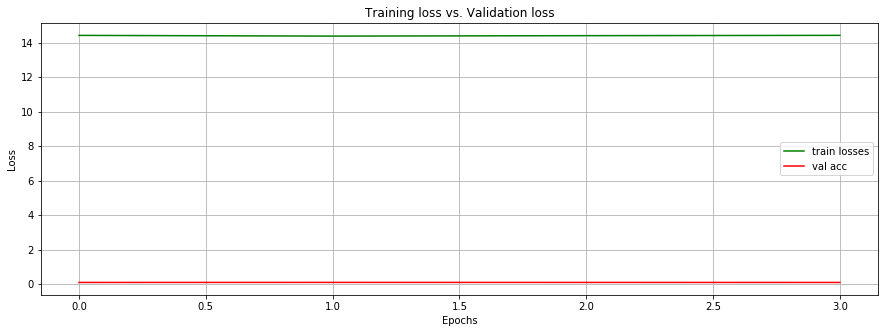

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(8, 5)) 
plt.plot(fitted_model.history['loss'], 'g', label="train losses") 
plt.plot(fitted_model.history['val_loss'], 'r', label="val loss") 
plt.grid(True) 
plt.title('Training loss vs. Validation loss') 
plt.xlabel('Epochs') 
plt.ylabel('Loss') 

fig = plt.figure(figsize=(8, 5)) 
plt.plot(fitted_model.history['acc'], 'g', label="train acc") 
plt.plot(fitted_model.history['val_acc'], 'r', label="val acc") 
plt.grid(True) 
plt.title('Training acc vs. Validation acc') 
plt.xlabel('Epochs') 
plt.ylabel('Acc') 
plt.legend() 

In [ ]:
test_generator = gen.flow_from_directory(".\\data\\test\\", (width, height),batch_size=16)
test = model.predict_generator(test_generator, test_generator.nb_sample)